## PARIS SUBSIDIES: MACHINE LEARNING

### LIBRAIRIES

In [142]:
# General data processing
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dtreeviz.trees import dtreeviz

# ML
# Encoding
from sklearn.preprocessing import MultiLabelBinarizer
# Selection
from sklearn.model_selection import train_test_split
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# Metrics & inspection
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# Imbalance
from imblearn.over_sampling import SMOTE

# String processing
from re import sub
from unidecode import unidecode
import string

# NLP
import spacy

### CUSTOM FUNCTIONS

In [2]:
def snake_case(s):
    # Convert a string to snake case
    # Adapted from https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-97.php
    return unidecode('_'.join(
        sub('([A-Z][a-z]+)', r' \1',
        sub('([A-Z]+)', r' \1',
        s.replace('-', ' ').replace('&', 'et'))).split()).lower())

In [3]:
def confusion_matrix_metrics(y_true, y_pred, pos_label):
    # Returns main metrics from binary confusion matrix
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label = pos_label)
    recall = recall_score(y_true, y_pred, pos_label = pos_label)
    precision = precision_score(y_true, y_pred, pos_label = pos_label)
    return accuracy, f1, recall, precision 

In [4]:
def show_metrics(X_train, y_train, X_test, y_test, pos_label, model):
    dct_scoring = dict()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    dct_scoring['train'] = confusion_matrix_metrics(y_train, y_train_pred, pos_label)
    dct_scoring['test'] = confusion_matrix_metrics(y_test, y_test_pred, pos_label)
    return pd.DataFrame.from_dict(dct_scoring, orient = 'index', columns = ['accuracy', 'f1', 'recall', 'precision'])


In [5]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    text2 = unidecode(text2)
    
    return text2.lower()

### DATA IMPORT

In [6]:
data = pd.read_feather('../00_DataFiles/05_NLPScoring/ParisSubsidies_NLPScoring.feather')

In [7]:
data.columns

Index(['numero_dossier', 'annee_budgetaire', 'siret', 'objet_dossier',
       'montant_vote', 'direction', 'nature_subvention', 'secteurs_activites',
       'categorie_entreprise', 'tranche_effectifs_unite_legale',
       'tranche_effectifs_unite_legale_triable', 'siret_siege_unite_legale',
       'etablissement_siege', 'code_postal_etablissement',
       'caractere_employeur_unite_legale', 'date_creation_unite_legale',
       'date_creation_etablissement', 'denomination_unite_legale',
       'adresse_etablissement_complete', 'latitude', 'longitude',
       'montant_vote_scale', 'montant_vote_cat', 'subsidy_granted_bool',
       'subsidy_granted', 'dpt_code', 'geo_cat', 'arrondissement',
       'nlp_scoring'],
      dtype='object')

### FEATURE PROCESSING

#### Feature creation

##### Age of association at request time

<AxesSubplot:xlabel='age_association_temp', ylabel='Count'>

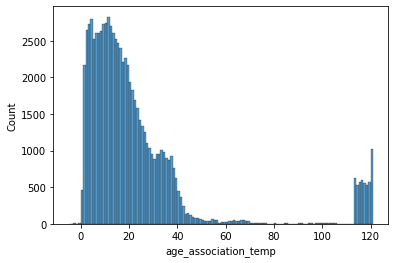

In [8]:
# Let's look at distribution
data['age_association_temp'] = data.annee_budgetaire - data.date_creation_unite_legale.dt.year
sns.histplot(data=data, x='age_association_temp', binwidth=1)

In [9]:
# We will split the associations into 3 categories

age_cats = ['<=1 year','2-5 years', '>5 years']

data['age_association'] = np.nan
data['age_association'] = np.where(data.age_association_temp <=1,age_cats[0],data['age_association'])
data['age_association'] = np.where((data.age_association_temp >1) & (data.age_association_temp <=5),age_cats[1],data['age_association'])
data['age_association'] = np.where(data.age_association_temp >5,age_cats[2],data['age_association'])


In [10]:
# Make it ordered categorical
data['age_association'] = pd.Categorical(data['age_association'], categories= age_cats, ordered=True)

In [11]:
# Drop temp columns
data.drop('age_association_temp', axis = 1, inplace = True)

<AxesSubplot:xlabel='age_association', ylabel='Count'>

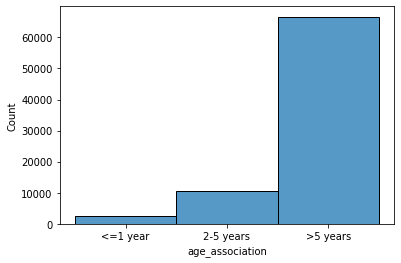

In [12]:
# Final distribution
sns.histplot(data=data, x='age_association', binwidth=1)

##### Previous request
Did the association previsouly requested a grant? Was it successful?

In [13]:
# Get numero_dossier of previous request, if any
data_numero_dossier_sorted = data.loc[:,['numero_dossier', 'siret', 'subsidy_granted']].sort_values(by='siret')
data_numero_dossier_sorted['numero_dossier_previous'] = np.nan
data_numero_dossier_sorted['subsidy_granted_previous'] = np.nan
for i in range(1, data_numero_dossier_sorted.index.max()+1):
    # Check if same siret
    if data_numero_dossier_sorted.iloc[i, 1] == data_numero_dossier_sorted.iloc[i-1, 1]:
        # Fill numero_dossier_previous
        data_numero_dossier_sorted.iloc[i, 3] = data_numero_dossier_sorted.iloc[i-1, 0]
        # Fill subsidy_granted_previous
        data_numero_dossier_sorted.iloc[i, 4] = data_numero_dossier_sorted.iloc[i-1, 2]

In [14]:
data_numero_dossier_sorted.head()

,numero_dossier,siret,subsidy_granted,numero_dossier_previous,subsidy_granted_previous
22317,2018_05914,03908456100016,yes,NaN,NaN
57895,2020_06713,03908456100016,yes,2018_05914,yes
38774,2017_07365,03908456100016,yes,2020_06713,yes
39459,2016_01585,03908456100016,yes,2017_07365,yes
45448,2019_02222,03908456100016,yes,2016_01585,yes


In [15]:
data_numero_dossier_sorted.tail()

,numero_dossier,siret,subsidy_granted,numero_dossier_previous,subsidy_granted_previous
68576,2021_11928,90351521100014,yes,2021_11927,yes
70157,2021_11961,90403473300017,no,NaN,NaN
73531,2021_11962,90403473300017,no,2021_11961,no
2044,2021_12073,90437936900013,yes,NaN,NaN
68916,2021_12166,90490688000011,yes,NaN,NaN


In [16]:
# Fill back to data
data = data.merge(data_numero_dossier_sorted.drop(['numero_dossier', 'siret', 'subsidy_granted', 'numero_dossier_previous'], axis = 1), how = 'left', left_index=True, right_index=True)

#### Feature selection

In [17]:
data.columns

Index(['numero_dossier', 'annee_budgetaire', 'siret', 'objet_dossier',
       'montant_vote', 'direction', 'nature_subvention', 'secteurs_activites',
       'categorie_entreprise', 'tranche_effectifs_unite_legale',
       'tranche_effectifs_unite_legale_triable', 'siret_siege_unite_legale',
       'etablissement_siege', 'code_postal_etablissement',
       'caractere_employeur_unite_legale', 'date_creation_unite_legale',
       'date_creation_etablissement', 'denomination_unite_legale',
       'adresse_etablissement_complete', 'latitude', 'longitude',
       'montant_vote_scale', 'montant_vote_cat', 'subsidy_granted_bool',
       'subsidy_granted', 'dpt_code', 'geo_cat', 'arrondissement',
       'nlp_scoring', 'age_association', 'subsidy_granted_previous'],
      dtype='object')

In [18]:
data.subsidy_granted_previous.value_counts()

yes    43881
no     24979
Name: subsidy_granted_previous, dtype: int64

In [19]:
features = ['direction', 'nature_subvention', 'secteurs_activites', 'geo_cat', 'nlp_scoring', 'age_association', 'subsidy_granted_previous']
X = data.loc[:, features].copy()
X.head()

,direction,nature_subvention,secteurs_activites,geo_cat,nlp_scoring,age_association,subsidy_granted_previous
0,DDCT,Fonctionnement,"[Loisirs, Social, Vie et animation locale]",Paris,0.782369,>5 years,yes
1,DASES,Fonctionnement,"[Loisirs, Social, Vie et animation locale]",Paris,0.643968,>5 years,yes
2,DAE,Non précisée,"[Environnement & écologie, Sport, Vie et anima...",IdF,0.526232,>5 years,yes
3,DASCO,Non précisée,"[Culture & Arts, Social, Sport]",Paris,0.446584,>5 years,yes
4,DFPE,Fonctionnement,"[Education & formation, Santé, Social]",Paris,0.796361,>5 years,yes


In [20]:
X.subsidy_granted_previous.value_counts()

yes    43881
no     24979
Name: subsidy_granted_previous, dtype: int64

#### Feature encoding

##### direction

In [21]:
# Distribution
X.direction.value_counts(normalize = True)

DDCT            0.217043
DAC             0.175473
DASES           0.124636
DJS             0.118895
DAE             0.086367
DFPE            0.058966
DASCO           0.055490
DPSP            0.043884
DPVI            0.036468
DGRI            0.026013
DEVE            0.020235
DPE             0.007966
SG              0.006015
DVD             0.005027
DPMP            0.004627
DUCT            0.003902
DGOM            0.003427
SG-MI-CINEMA    0.001488
DLH             0.001326
DU              0.000925
DRH             0.000663
DFA             0.000563
DICOM           0.000288
CASVP           0.000075
DAJ             0.000075
SG-DPMC         0.000063
SGCP            0.000050
DILT            0.000050
Name: direction, dtype: float64

In [22]:
# Cumulative distribution
X.direction.value_counts(normalize = True).cumsum()

DDCT            0.217043
DAC             0.392516
DASES           0.517152
DJS             0.636048
DAE             0.722415
DFPE            0.781381
DASCO           0.836870
DPSP            0.880754
DPVI            0.917222
DGRI            0.943235
DEVE            0.963470
DPE             0.971436
SG              0.977452
DVD             0.982479
DPMP            0.987106
DUCT            0.991008
DGOM            0.994435
SG-MI-CINEMA    0.995923
DLH             0.997249
DU              0.998174
DRH             0.998837
DFA             0.999400
DICOM           0.999687
CASVP           0.999762
DAJ             0.999837
SG-DPMC         0.999900
SGCP            0.999950
DILT            1.000000
Name: direction, dtype: float64

In [23]:
# We will identify the top 7 directions (min 5% of data, cumul more than 80%) and group the others
# Manual dummy encoding
directions_top = ['DDCT','DAC','DASES','DJS','DAE','DFPE','DASCO']
for dir in directions_top:
    X[dir] = np.where(X.direction == dir, 1, 0)

##### nature_subvention

In [24]:
X.nature_subvention.value_counts()

Non précisée      29549
Projet            24490
Fonctionnement    24044
Investissement     1878
Name: nature_subvention, dtype: int64

In [25]:
# Manual dummy encoding
X['projet'] = np.where(X.nature_subvention == 'Projet', 1, 0)
X['fonctionnement'] = np.where(X.nature_subvention == 'Fonctionnement', 1, 0)
X['investissement'] = np.where(X.nature_subvention == 'Investissement', 1, 0)

##### secteurs_activites

In [26]:
# Init and fit encoder
mlb = MultiLabelBinarizer()
mlb.fit(X.secteurs_activites)

MultiLabelBinarizer()

In [27]:
# Store in a dataframe
df_secteurs_activities = pd.DataFrame(mlb.transform(X.secteurs_activites), index=X.index, columns=mlb.classes_)

# Display distribution
df_secteurs_activities.sum(axis = 0).sort_values(ascending=False)

Culture & Arts                        31832
Social                                31377
Education & formation                 28797
Vie et animation locale               28056
Précarité & Exclusion                 11752
Sport                                 11632
Loisirs                               10479
Santé                                  7592
Emploi                                 7479
Défense des droits et des intérêts     5766
Environnement & écologie               5549
Mémoire                                3694
Humanitaire                            3354
Aides aux associations                 2903
Communication & média                  2656
Relations internationales              2308
Economie                               2104
Technique & Recherche                  1446
Idée & opinion                         1262
Architecture & urbanisme               1250
Tourisme                                833
Déplacements et transports              614
dtype: int64

<AxesSubplot:>

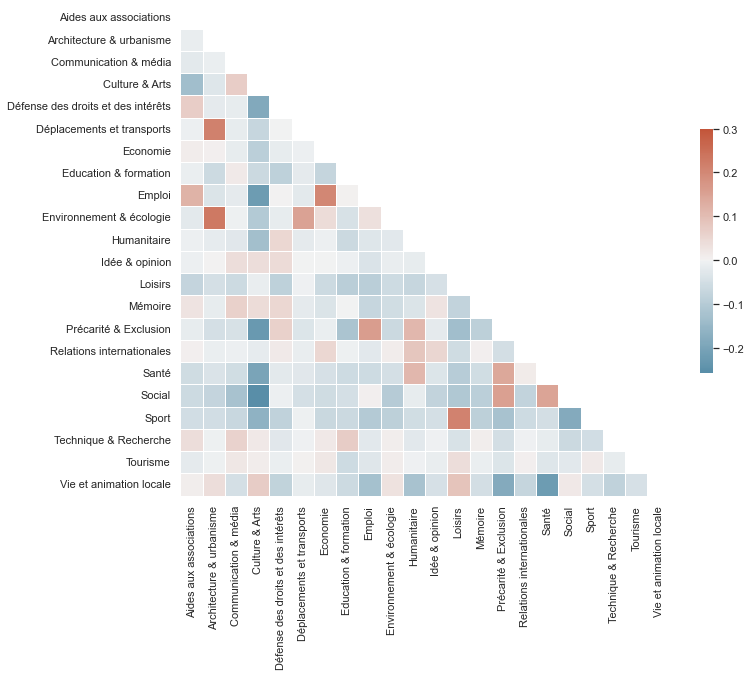

In [28]:
# Too many categories, let's reduce the number
# Display correlation matrix

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_secteurs_activities.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
# No strong correlation
# Let's look at the number of rows with a single 'secteurs_activites'
df_secteurs_activities.loc[df_secteurs_activities.sum(axis=1) == 1].sum(axis = 0).sort_values(ascending=False)

Culture & Arts                        5912
Sport                                 2221
Social                                1642
Education & formation                  744
Vie et animation locale                521
Santé                                  398
Mémoire                                366
Défense des droits et des intérêts     239
Précarité & Exclusion                  188
Humanitaire                            164
Environnement & écologie               130
Emploi                                 124
Loisirs                                 52
Economie                                49
Relations internationales               44
Architecture & urbanisme                37
Tourisme                                35
Communication & média                   33
Aides aux associations                  22
Idée & opinion                          16
Technique & Recherche                    5
Déplacements et transports               3
dtype: int64

In [30]:
# We will keep only the secteurs_activites with more than 10,000 occurrences (i.e. top 7)
secteurs_activites_selected = df_secteurs_activities.sum(axis = 0).sort_values(ascending=False).index[0:7].to_list()
secteurs_activites_selected

['Culture & Arts',
 'Social',
 'Education & formation',
 'Vie et animation locale',
 'Précarité & Exclusion',
 'Sport',
 'Loisirs']

In [31]:
# Drop the columns of other secteurs_activities
for col in df_secteurs_activities.columns:
    if col not in secteurs_activites_selected:
        df_secteurs_activities.drop(col, axis = 1, inplace = True)

In [32]:
# Rename columns
df_secteurs_activities.rename(snake_case, axis = 1, inplace = True)

In [33]:
# Fill results back to X
X = X.merge(df_secteurs_activities, how = 'left', left_index=True, right_index=True)

#### geo_cat

In [34]:
# Manual dummy encoding
X['paris'] = np.where(X.geo_cat == 'Paris', 1, 0)
X['idf'] = np.where(X.geo_cat == 'IdF', 1, 0)

##### age_association


In [35]:
# Manual ordinal encoder
X.age_association = np.where(X.age_association=='<=1 year', 0, X.age_association)
X.age_association = np.where(X.age_association=='2-5 years', 1, X.age_association)
X.age_association = np.where(X.age_association=='>5 years', 2, X.age_association)

##### subsidy_granted_previous

In [36]:
# Column to store whether there was a previous request
X['previous_request'] = np.where(X.subsidy_granted_previous.isna(), 0, 1)

# Column to store success
X['previous_request_success'] = np.nan
X['previous_request_success'] = np.where(X.subsidy_granted_previous.isna(), -1, X['previous_request_success'])
X['previous_request_success'] = np.where(X.subsidy_granted_previous == 'no', 0, X['previous_request_success'])
X['previous_request_success'] = np.where(X.subsidy_granted_previous == 'yes', 1, X['previous_request_success'])

##### Final cleaning & checks

In [37]:
# Drop non encoded features
X.drop([f for f in features if f != 'nlp_scoring'], axis = 1, inplace = True)

<AxesSubplot:>

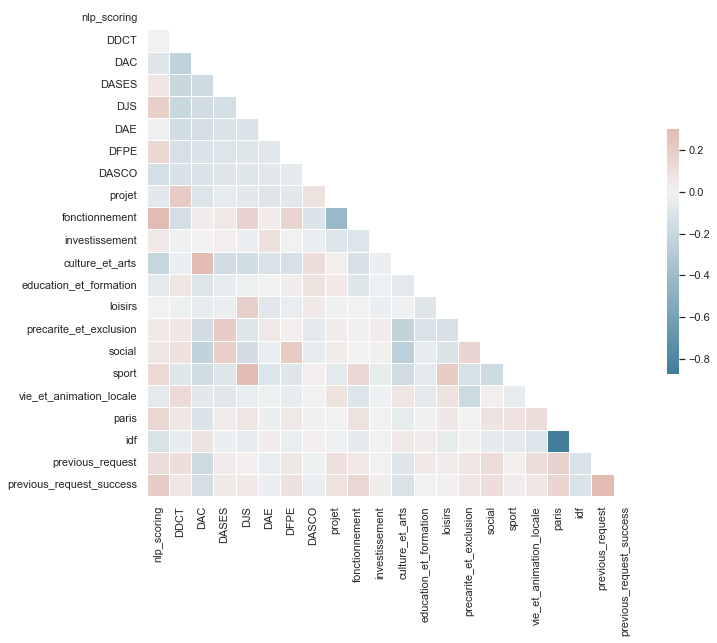

In [38]:
# Collinearity
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
# paris and idf are very (negatively) correlated
# It is not surprising as most of the associations are either in Paris or in IdF, not so much beyond
# Also we saw in the EDA that the reject rate is quite similar between IdF and Beyond
# We can remove idf
X.drop('idf', axis = 1, inplace = True)

In [40]:
# Final check
X.describe().T

,count,mean,std,min,25%,50%,75%,max
nlp_scoring,79961.0,0.585309,0.112239,0.0,0.515604,0.567923,0.659362,0.953058
DDCT,79961.0,0.217043,0.412235,0.0,0.000000,0.000000,0.000000,1.000000
DAC,79961.0,0.175473,0.380374,0.0,0.000000,0.000000,0.000000,1.000000
DASES,79961.0,0.124636,0.330308,0.0,0.000000,0.000000,0.000000,1.000000
DJS,79961.0,0.118895,0.323667,0.0,0.000000,0.000000,0.000000,1.000000
DAE,79961.0,0.086367,0.280907,0.0,0.000000,0.000000,0.000000,1.000000
DFPE,79961.0,0.058966,0.235563,0.0,0.000000,0.000000,0.000000,1.000000
DASCO,79961.0,0.055490,0.228935,0.0,0.000000,0.000000,0.000000,1.000000
projet,79961.0,0.306274,0.460948,0.0,0.000000,0.000000,1.000000,1.000000
fonctionnement,79961.0,0.300697,0.458564,0.0,0.000000,0.000000,1.000000,1.000000


In [41]:
# Seems all in order
features = X.columns

### MACHINE LEARNING: TRY 1

#### Train vs. test data

In [42]:
y = data.subsidy_granted_bool
print(X.shape)
print(y.shape)

(79961, 21)
(79961,)


In [43]:
# random_state = 42 so we get the same split as in NLP
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Decision Tree Classifier

In [44]:
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X_train, y_train)

In [45]:
confusion_matrix(y_train, dtc.predict(X_train))

array([[24814,   136],
       [  212, 38806]])

In [46]:
confusion_matrix(y_test, dtc.predict(X_test))

array([[5660,  580],
       [ 604, 9149]])

In [47]:
show_metrics(X_train, y_train, X_test, y_test, pos_label=True, model = dtc)

,accuracy,f1,recall,precision
train,0.994560,0.995536,0.994567,0.996508
test,0.925968,0.939226,0.938070,0.940384


Very high scores! Let's examine if some features have an overwhelming importance.

In [48]:
# Get weights
importance = dtc.feature_importances_

# Put in dictionary
dct_features_importance = {f:i for (f,i) in zip(X_train.columns, importance)}

# Sort by importance
dct_features_importance = dict(sorted(dct_features_importance.items(), key=lambda item: item[1], reverse = True))

# Summarize feature importance
pd.DataFrame.from_dict(dct_features_importance, orient = 'index', columns = ['importance'])

,importance
projet,0.546772
fonctionnement,0.221601
nlp_scoring,0.097422
investissement,0.083140
previous_request_success,0.007966
culture_et_arts,0.005151
vie_et_animation_locale,0.004875
education_et_formation,0.004815
social,0.003931
DDCT,0.003717


project, fonctionnement, and investissement are of the same nature (nature_subvention) and are standing out.

Let's check with other models.

#### Support Vector Classification

In [49]:
#svc = SVC(verbose=True)
#svc.fit(X_train, y_train)

In [50]:
#show_metrics(X_train, y_train, X_test, y_test, pos_label=True, model = svc)

Very high scores again.

#### Logistic Regression

In [51]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [52]:
show_metrics(X_train, y_train, X_test, y_test, pos_label=True, model = lr)

,accuracy,f1,recall,precision
train,0.959417,0.967263,0.982905,0.952110
test,0.959107,0.967020,0.983082,0.951474


Let's look at coefficients.

In [53]:
# Get weights
importance = lr.coef_[0]

# Put in dictionary
dct_features_importance = {f:i for (f,i) in zip(X_train.columns, importance)}

# Sort by importance
dct_features_importance = dict(sorted(dct_features_importance.items(), key=lambda item: item[1], reverse = True))

# Summarize feature importance
pd.DataFrame.from_dict(dct_features_importance, orient = 'index', columns = ['coef'])

,coef
projet,7.047560
investissement,6.721273
fonctionnement,6.432211
nlp_scoring,5.132977
previous_request_success,0.446061
DASES,0.117563
paris,0.104367
culture_et_arts,0.077581
social,0.051258
education_et_formation,-0.017287


Again, projet, investissement and fonctionnement are standing out.

Updated EDA view shows that the reject rate for the requests tagged as project, investissement or fonctionnement is very low (<4%) while it is very high (>97%) if the request is taggued as 'Non précisée'.

Maybe this is not a piece of information provided by the association, but a field filled a posteriori by the public servants... and they do not bother filling it if the request was rejected.

In this case, we should take these features out.

### MACHINE LEARNING: TRY 2

#### Feature reduction

In [54]:
X_train_red = X_train.drop(['fonctionnement', 'investissement', 'projet'], axis = 1)
X_test_red = X_test.drop(['fonctionnement', 'investissement', 'projet'], axis = 1)

#### Decision Tree Classifier

In [55]:
dtc.fit(X_train_red, y_train)
show_metrics(X_train_red, y_train, X_test_red, y_test, pos_label=True, model = dtc)

,accuracy,f1,recall,precision
train,0.965045,0.971168,0.965144,0.977267
test,0.646033,0.710805,0.713319,0.708308


Clear overfit, we should hypertune it.

In [56]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5],
    'min_samples_leaf': [50, 100],
    'criterion': ["gini", "entropy"]
}

In [57]:
grid_search = GridSearchCV(estimator=dtc, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [58]:
%%time
grid_search.fit(X_train_red, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 168 ms, sys: 193 ms, total: 361 ms
Wall time: 2.56 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5],
                         'min_samples_leaf': [50, 100]},
             scoring='f1', verbose=1)

In [59]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,0.052819,0.006826,0.008564,0.002323,gini,3,50,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787415,0.787407,0.784070,0.790025,0.787229,0.002113,1
3,0.044993,0.001447,0.008281,0.001625,gini,3,100,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787415,0.787407,0.784070,0.790025,0.787229,0.002113,1
8,0.042144,0.002133,0.007358,0.002607,entropy,3,50,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.785588,0.787375,0.784070,0.769383,0.781604,0.007152,3
9,0.039854,0.001531,0.007155,0.002514,entropy,3,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.785588,0.787375,0.784070,0.769383,0.781604,0.007152,3
4,0.070926,0.009380,0.009812,0.003642,gini,5,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.784649,0.780639,0.779112,0.781500,0.781475,0.002022,5


In [60]:
dtc_best = grid_search.best_estimator_
dtc_best

DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=42)

In [61]:
show_metrics(X_train_red, y_train, X_test_red, y_test, pos_label=True, model = dtc_best)

,accuracy,f1,recall,precision
train,0.712403,0.787266,0.872443,0.717242
test,0.674420,0.759636,0.843638,0.690848


Best model for DTC, let's look at features importance.

In [62]:
# Get weights
importance = dtc_best.feature_importances_

# Put in dictionary
dct_features_importance = {f:i for (f,i) in zip(X_train_red.columns, importance)}

# Sort by importance
dct_features_importance = dict(sorted(dct_features_importance.items(), key=lambda item: item[1], reverse = True))

# Summarize feature importance
pd.DataFrame.from_dict(dct_features_importance, orient = 'index', columns = ['importance'])

,importance
nlp_scoring,0.896026
previous_request_success,0.103974
DDCT,0.000000
DAC,0.000000
DASES,0.000000
DJS,0.000000
DAE,0.000000
DFPE,0.000000
DASCO,0.000000
culture_et_arts,0.000000


It is now essentially depending on the description and the success of a previous request.

Let's reduce again the features by taking out the direction (likely the association cannot choose the direction to which it refers its request). We can also drop the 'previous_request' feature as the information is also contained with 'previous_request_success' (-1 if no previous request).

In [63]:
X_train_red_red = X_train_red.drop(['DDCT', 'DAC', 'DFPE', 'DASES', 'DJS', 'DAE', 'DASCO', 'previous_request'], axis = 1)
X_test_red_red = X_test_red.drop(['DDCT', 'DAC', 'DFPE', 'DASES', 'DJS', 'DAE', 'DASCO', 'previous_request'], axis = 1)

In [64]:
%%time
grid_search.fit(X_train_red_red, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 105 ms, sys: 65.2 ms, total: 170 ms
Wall time: 681 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5],
                         'min_samples_leaf': [50, 100]},
             scoring='f1', verbose=1)

In [65]:
dtc_best = grid_search.best_estimator_
dtc_best

DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=42)

In [66]:
show_metrics(X_train_red_red, y_train, X_test_red_red, y_test, pos_label=True, model = dtc_best)

,accuracy,f1,recall,precision
train,0.712403,0.787266,0.872443,0.717242
test,0.674420,0.759636,0.843638,0.690848


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


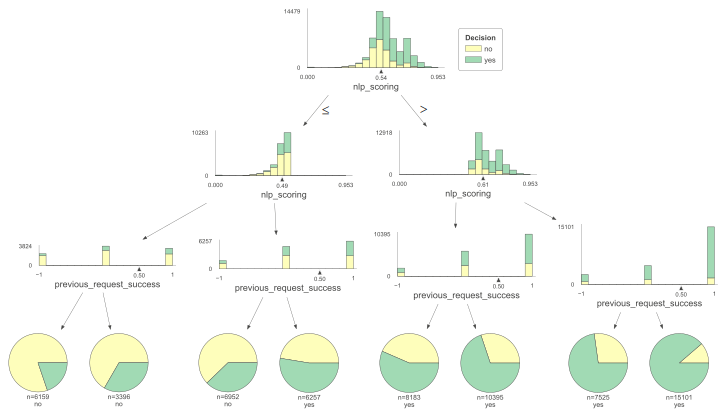

In [67]:
class_names = {True:'yes', False:'no'}

viz = dtreeviz(dtc_best, X_train_red_red, y_train,
                target_name = 'Decision',
                feature_names=dtc_best.feature_names_in_,
                class_names=class_names)

viz

#### Logistic Regression

In [68]:
lr.fit(X_train_red_red, y_train)
show_metrics(X_train_red_red, y_train, X_test_red_red, y_test, pos_label=True, model = lr)

,accuracy,f1,recall,precision
train,0.709448,0.777130,0.830488,0.730215
test,0.679922,0.754331,0.805803,0.709040


Let's look at the coefficients.

In [69]:
# Get weights
importance = lr.coef_[0]

# Put in dictionary
dct_features_importance = {f:i for (f,i) in zip(X_train_red_red.columns, importance)}

# Sort by importance
dct_features_importance = dict(sorted(dct_features_importance.items(), key=lambda item: item[1], reverse = True))

# Summarize feature importance
pd.DataFrame.from_dict(dct_features_importance, orient = 'index', columns = ['coef'])

,coef
nlp_scoring,8.792818
previous_request_success,0.508862
paris,0.068288
vie_et_animation_locale,-0.072402
culture_et_arts,-0.099349
social,-0.105157
precarite_et_exclusion,-0.107716
sport,-0.138238
education_et_formation,-0.162471
loisirs,-0.181557


#### Predict proba

##### Request to test

In [70]:
dct_request_test = {
    'nlp_scoring':'',
    'culture_et_arts':'1',
    'education_et_formation':'0',
    'loisirs':'1',
    'precarite_et_exclusion':'0',
    'social':'0',
    'sport':'0',
    'vie_et_animation_locale':'1',
    'paris':'0',
    'previous_request_success':'0',
    'objet_dossier':'une grosse bagnole diesel pour renverser les vélociplédistes'
}

##### NLP processing

In [71]:
nlp_textcat = spacy.load('../05_NLP/textcat_output/model-best')
dct_request_test['nlp_scoring'] = nlp_textcat(clean_text(dct_request_test['objet_dossier'])).cats['yes']

In [72]:
dct_request_test['nlp_scoring']

0.5293053984642029

In [73]:
df_request = pd.DataFrame.from_dict(dct_request_test, orient = 'index').T

In [74]:
dtc_best.predict_proba(df_request.drop(['objet_dossier'], axis = 1))

array([[0.62197929, 0.37802071]])

In [75]:
# Trying different objet_dossier

objets_dossier = ['construction d\'un foyer pour mineurs isolés', 'un jardin partagé pour les enfants et les personnes âgées', 'des sous pour manger des popcorns au cinéma','une grosse bagnole diesel pour renverser les vélociplédistes', 'blah blah blah pookie']

for i in range(len(objets_dossier)):
    print(objets_dossier[i])
    dct_request_test['objet_dossier'] = objets_dossier[i]
    dct_request_test['nlp_scoring'] = nlp_textcat(clean_text(dct_request_test['objet_dossier'])).cats['yes']
    df_request = pd.DataFrame.from_dict(dct_request_test, orient = 'index').T
    print(f'Chance : {dtc_best.predict_proba(df_request.drop(["objet_dossier"], axis = 1))[0][1]:.0%}')

construction d'un foyer pour mineurs isolés
Chance : 38%
un jardin partagé pour les enfants et les personnes âgées
Chance : 57%
des sous pour manger des popcorns au cinéma
Chance : 57%
une grosse bagnole diesel pour renverser les vélociplédistes
Chance : 38%
blah blah blah pookie
Chance : 20%


### MACHINE LEARNING: AND THE AMOUNT?
We will now try to estimate the amount.

#### Dataset reduction
Given the large range of possible values, we will focus on the 1-10k EUR segment, which accounts for more than 50% of successful requests.

We will also restrict to associations based in Paris so we can factor in the location without outliers.

In [368]:
# Get list of indices to keep
lst_idxs = data.loc[(data.montant_vote_scale == 3) & (data.geo_cat == 'Paris')].index.to_list()
print(f'Subset size = {len(lst_idxs)/data.shape[0]:.0%} of total dataset and {len(lst_idxs)/data.loc[data.subsidy_granted_bool == True].shape[0]:.0%} of successful requests')

Subset size = 34% of total dataset and 56% of successful requests


In [369]:
X_amt = X.loc[lst_idxs]

#### Feature selection

In [370]:
# Select features
X_amt = X_amt.drop(['fonctionnement', 'investissement', 'projet', 'DDCT', 'DAC', 'DFPE', 'DASES', 'DJS', 'DAE', 'DASCO', 'previous_request', 'previous_request_success', 'paris'], axis = 1)
X_amt.columns

Index(['nlp_scoring', 'culture_et_arts', 'education_et_formation', 'loisirs',
       'precarite_et_exclusion', 'social', 'sport', 'vie_et_animation_locale'],
      dtype='object')

In [383]:
# Select target
y_amt = data.loc[(data.montant_vote_scale == 3) & (data.geo_cat == 'Paris'), 'montant_vote']

<AxesSubplot:xlabel='montant_vote', ylabel='Count'>

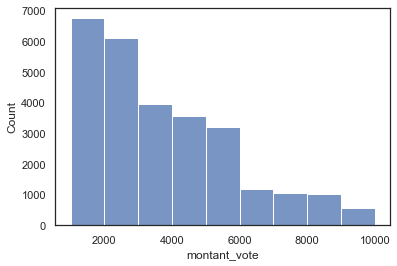

In [384]:
# Distribution
sns.histplot(y_amt, binwidth=1000, binrange=[1000,10000])

In [373]:
# We can group in three categories = 1-2k, 3-5k, >5k EUR
y_amt = pd.cut(y_amt, bins = [1000,3000,6000,10000], right = False, include_lowest=True, ordered=True, labels=['1-2k', '3-5k', '6-10k'])
y_amt.value_counts()

1-2k     12841
3-5k     10687
6-10k     3800
Name: montant_vote, dtype: int64

In [374]:
# The last category is in minority, we  will need to account for the imbalance

#### Train / test split

In [375]:
X_amt_train, X_amt_test, y_amt_train, y_amt_test = train_test_split(X_amt, y_amt, test_size=0.2, random_state=42)

In [376]:
# Oversample on train data
oversample = SMOTE()
X_amt_train, y_amt_train = oversample.fit_resample(X_amt_train, y_amt_train)
y_amt_train.value_counts()

1-2k     10203
3-5k     10203
6-10k    10203
Name: montant_vote, dtype: int64

#### KNC

In [398]:
3 # Hyperparameter tuning

knc = KNeighborsClassifier()

grid_params = {
    'n_neighbors':[3,5,10,20,50],
    'weights':['uniform', 'distance'],
    'p':[1,2]
}

gs = GridSearchCV(estimator=knc, 
                           param_grid=grid_params, 
                           cv=4, n_jobs=-1, scoring = 'f1_weighted', verbose=1)

In [399]:
%%time
gs.fit(X_amt_train, y_amt_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
CPU times: user 178 ms, sys: 59.9 ms, total: 238 ms
Wall time: 6.05 s


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 10, 20, 50], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted', verbose=1)

In [400]:
score_df = pd.DataFrame(gs.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,0.028327,0.007083,0.629586,0.024854,50,1,distance,"{'n_neighbors': 50, 'p': 1, 'weights': 'distan...",0.551889,0.564158,0.558071,0.582995,0.564278,0.011644,1
19,0.027614,0.006441,0.577427,0.017298,50,2,distance,"{'n_neighbors': 50, 'p': 2, 'weights': 'distan...",0.551889,0.564158,0.558071,0.582995,0.564278,0.011644,1
13,0.030462,0.002389,0.495420,0.011975,20,1,distance,"{'n_neighbors': 20, 'p': 1, 'weights': 'distan...",0.551147,0.561165,0.557732,0.580081,0.562531,0.010753,3
15,0.023110,0.004879,0.449449,0.027319,20,2,distance,"{'n_neighbors': 20, 'p': 2, 'weights': 'distan...",0.551147,0.561165,0.557732,0.580081,0.562531,0.010753,3
9,0.024433,0.003469,0.441084,0.037029,10,1,distance,"{'n_neighbors': 10, 'p': 1, 'weights': 'distan...",0.544578,0.549256,0.550968,0.575883,0.555171,0.012184,5


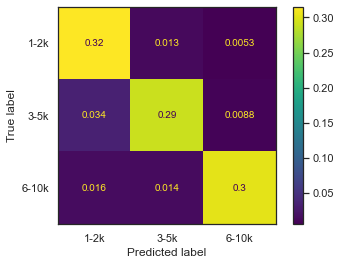

In [401]:
ConfusionMatrixDisplay.from_predictions(y_amt_train, gs.best_estimator_.predict(X_amt_train), normalize='all')

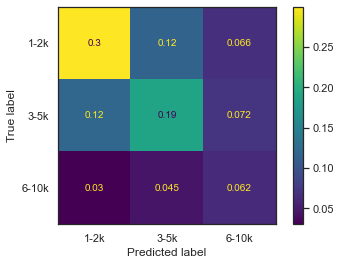

In [402]:
ConfusionMatrixDisplay.from_predictions(y_amt_test, gs.best_estimator_.predict(X_amt_test), normalize='all')

Not a great result due to side & edge effects